# OpenIFS biases

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41195 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:46387 Dashboard: http://127.0.0.1:41195/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [6]:
exp_list = ['FOCI_GJK001']
times_list = [slice('2350-01-01','2850-01-01')]

In [7]:
# OpenIFS surface
ds_sfc_all = []
for exp,times in zip(exp_list,times_list):
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=times)
    ds_sfc_all.append(ds_sfc)

In [8]:
# OpenIFS plev
ds_pl_all = []
for exp,times in zip(exp_list,times_list):
    pl = '%s/%s/outdata/oifs/*1m*regular_pl.nc' % (esmdir,exp)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=times)
    ds_pl_all.append(ds_pl)

In [9]:
ds_pl

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lat: 96, lon: 192, pressure_levels: 39, time: 6000)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * pressure_levels       (pressure_levels) float32 1e+05 9.25e+04 ... 5.0 3.0
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 2350-01-16 12:00:00 ... 2849-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    z                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(120, 39, 96, 192), meta=np.ndarray>
    t                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(120, 39, 96, 192), meta=np.ndarray>
    u                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(120, 39, 96, 192), meta=np.ndarray>
    v                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(120, 39, 96, 192), meta=np.ndarray>
    q                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(120, 39, 96, 192), meta=np.ndarray>
    w                     (time, pressure_levels, lat, lon) float32 dask.array<chunksize=(120, 39, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_18500101_regular_pl
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2021-Nov-12 19:21:57 GMT
    uuid:         b51a6ec5-24d5-48b7-b7a6-250759793a4b
    history:      Sun Nov 14 21:27:08 2021: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

## SST and CI

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


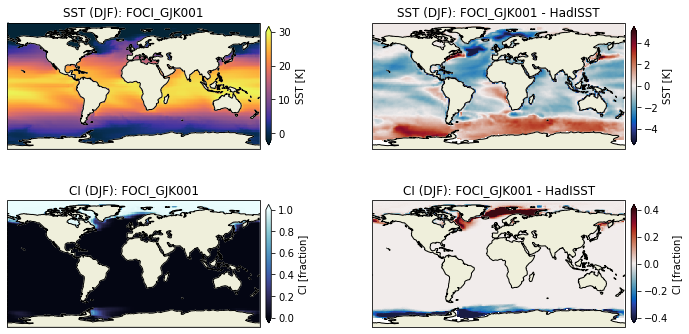

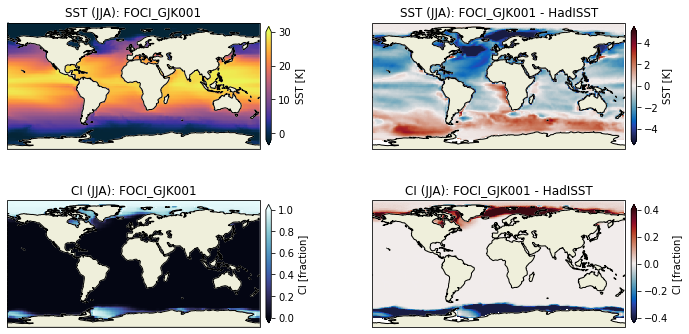

In [10]:
# Plot settings
prj = ccrs.PlateCarree()
tmin1 = -2
tmax1 = 30
tmin2 = -5
tmax2 = 5
cmin1 = 0
cmax1 = 1
cmin2 = -0.4
cmax2 = 0.4

cmap1 = cmocean.cm.thermal
cmap2 = cmocean.cm.balance
imap1 = cmocean.cm.ice
imap2 = cmocean.cm.balance

# HadSST and ice
if machine == 'sci':
    hadisst = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'
    hadiice = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_ice.nc'
elif machine == 'nesh':
    hadisst = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_sst.nc'
    hadiice = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_ice.nc'

ds_hadsst = xr.open_dataset(hadisst).rename({'longitude':'lon','latitude':'lat'})
ds_hadice = xr.open_dataset(hadiice).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
sic_had = ds_hadice['sic'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    
    # Convert SST to Celsius and CI to percent
    sst = ds_sfc['sstk'].groupby('time.season').mean('time') - 273.15
    ci  = ds_sfc['ci'].groupby('time.season').mean('time') 
    
    sst_180 = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180))
    ci_180  = ci.assign_coords(lon=(((ci.lon + 180) % 360) - 180))
    
    sst_i = sst_180.interp_like(sst_had)
    ci_i  = ci_180.interp_like(sic_had)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        for ax in axs: ax.add_feature(cfeature.LAND,zorder=1)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
        sst.sel(season=season).plot(ax=axs[0],vmin=tmin1,vmax=tmax1,cmap=cmap1,cbar_kwargs=ckw)
        (sst_i - sst_had).sel(season=season).plot(ax=axs[1],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'CI [fraction]'}
        ci.sel(season=season).plot(ax=axs[2],vmin=cmin1,vmax=cmax1,cmap=imap1,cbar_kwargs=ckw)
        (ci_i - sic_had).sel(season=season).plot(ax=axs[3],cmap=imap2,vmin=cmin2,vmax=cmax2,cbar_kwargs=ckw)
        
        axs[1].set_title('SST (%s): %s - HadISST' % (season,exp))
        axs[0].set_title('SST (%s): %s' % (season,exp))
        axs[3].set_title('CI (%s): %s - HadISST' % (season,exp))
        axs[2].set_title('CI (%s): %s' % (season,exp))
        
        for ax in axs:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        fig.tight_layout()
        fig.savefig('sst_biases_%s.png' % (season,),format='png',dpi=600)


In [ ]:
# Recreate Matthes et al 2020
prj = ccrs.PlateCarree()
tmin2 = -6
tmax2 = 6

cmap1 = cmocean.cm.thermal
cmap2 = cmocean.cm.balance

# HadSST and ice
if machine == 'sci':
    hadisst = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_sst.nc'
    hadiice = '/data/user/swahl/reanalysis_obs/HADISST/HadISST_ice.nc'
elif machine == 'nesh':
    hadisst = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_sst.nc'
    hadiice = '/gxfs_work1/geomar/smomw352/reanalysis_obs/HadISST_ice.nc'

ds_hadsst = xr.open_dataset(hadisst).rename({'longitude':'lon','latitude':'lat'})
ds_hadice = xr.open_dataset(hadiice).rename({'longitude':'lon','latitude':'lat'})

sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
sst_had = sst_had.sel(time=slice('1870-01-01','1900-01-01')).mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    
    # Convert SST to Celsius and CI to percent
    sst = ds_sfc['sstk'].mean('time') - 273.15
    sst_180 = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180))
    sst_i = sst_180.interp_like(sst_had)
    
    fig = plt.figure(figsize=(6,10))
    axs = []
    axs.append( fig.add_subplot(2,1,1,projection=prj) )
    axs.append( fig.add_subplot(2,1,2,projection=prj) )
        
    for ax in axs: ax.add_feature(cfeature.LAND,zorder=1)
        
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'SST [K]'}
    (sst_i - sst_had).plot.pcolormesh(ax=axs[0],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
    (sst_i - sst_had).plot.pcolormesh(ax=axs[1],cmap=cmap2,vmin=tmin2,vmax=tmax2,cbar_kwargs=ckw)
    (sst_i - sst_had).plot.contour(ax=axs[0],colors='k',levels=np.arange(tmin2,tmax2+1,1))
    (sst_i - sst_had).plot.contour(ax=axs[1],colors='k',levels=np.arange(tmin2,tmax2+1,1))
    
    for ax in axs:
        ax.coastlines()
        ax.set_title('SST: %s - HadISST' % (exp,))
        ax.set_aspect('auto')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right = False
        gl.xlines = False
        gl.ylines = False
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        #gl.xlabel_style = {'size': 15, 'color': 'gray'}
        #gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

    axs[0].set_extent([-90,0,20,75],crs=prj)
    axs[1].set_extent([-50,20,-30,20],crs=prj)
        
    fig.tight_layout()
    fig.savefig('sst_biases_as_matthes2020_%s.png' % (exp,),format='png',dpi=600)


## Surface pressure and zonal wind

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lat: 96, lon: 192, time: 1200)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 2300-01-16 12:00:00 ... 2399-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/43)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192),

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


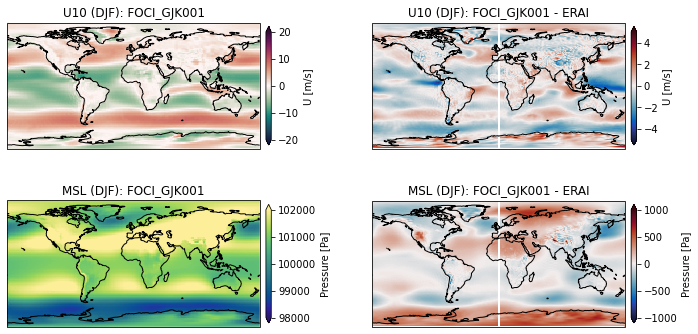

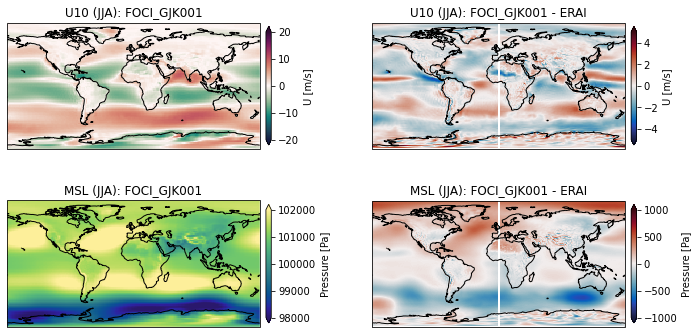

In [23]:
# Plot settings
prj = ccrs.PlateCarree()
umin1 = -20
umax1 = 20
umin2 = -5
umax2 = 5
pmin1 = 98000
pmax1 = 102000
pmin2 = -1000
pmax2 = 1000

umap1 = cmocean.cm.curl
umap2 = cmocean.cm.balance
pmap1 = cmocean.cm.haline
pmap2 = cmocean.cm.balance

# ERA-Int
if machine == 'sci':
    era_msl = '/data/user/swahl/reanalysis_obs/era40-int/surface/msl/msl-eraint_monthly_0.75deg_1979-2017.nc'
    era_u10 = '/data/user/swahl/reanalysis_obs/era40-int/surface/u10/u10-eraint_monthly_0.75deg_1979-2017.nc'
elif machine == 'nesh':
    era_msl = '/gxfs_work1/geomar/smomw352/reanalysis_obs/msl-eraint_monthly_0.75deg_1979-2017.nc'
    era_u10 = '/gxfs_work1/geomar/smomw352/reanalysis_obs/u10-eraint_monthly_0.75deg_1979-2017.nc'
    
ds_era_msl = xr.open_dataset(era_msl)#.rename({'longitude':'lon','latitude':'lat'})
ds_era_u10 = xr.open_dataset(era_u10)#.rename({'longitude':'lon','latitude':'lat'})

msl_ei = ds_era_msl['MSL'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
u10_ei = ds_era_u10['U10M'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    print(ds_sfc)
    
    u10 = ds_sfc['10u'][-360:].groupby('time.season').mean('time') 
    msl = ds_sfc['msl'][-360:].groupby('time.season').mean('time') 
    
    u10_i = u10.interp_like(u10_ei)
    msl_i = msl.interp_like(msl_ei)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(12,6))
        axs = []
        axs.append( fig.add_subplot(2,2,1,projection=prj) )
        axs.append( fig.add_subplot(2,2,2,projection=prj) )
        axs.append( fig.add_subplot(2,2,3,projection=prj) )
        axs.append( fig.add_subplot(2,2,4,projection=prj) )
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]'}
        u10.sel(season=season).plot(ax=axs[0],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        (u10_i - u10_ei).sel(season=season).plot(ax=axs[1],cmap=umap2,vmin=umin2,vmax=umax2,cbar_kwargs=ckw)
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'Pressure [Pa]'}
        msl.sel(season=season).plot(ax=axs[2],vmin=pmin1,vmax=pmax1,cmap=pmap1,cbar_kwargs=ckw)
        (msl_i - msl_ei).sel(season=season).plot(ax=axs[3],cmap=pmap2,vmin=pmin2,vmax=pmax2,cbar_kwargs=ckw)
        
        axs[1].set_title('U10 (%s): %s - ERAI' % (season,exp))
        axs[0].set_title('U10 (%s): %s' % (season,exp))
        axs[3].set_title('MSL (%s): %s - ERAI' % (season,exp))
        axs[2].set_title('MSL (%s): %s' % (season,exp))
        
        for ax in axs:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        fig.tight_layout()
        fig.savefig('u10_msl_biases_%s.png' % (season,),format='png',dpi=600)


## Winds

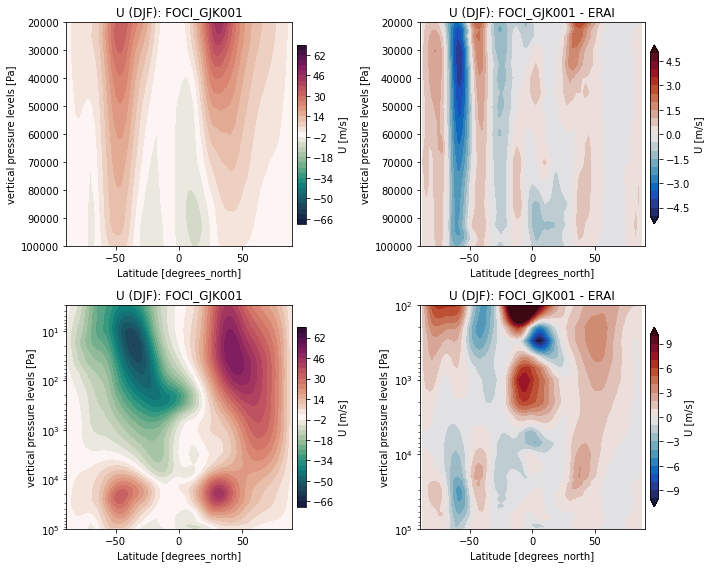

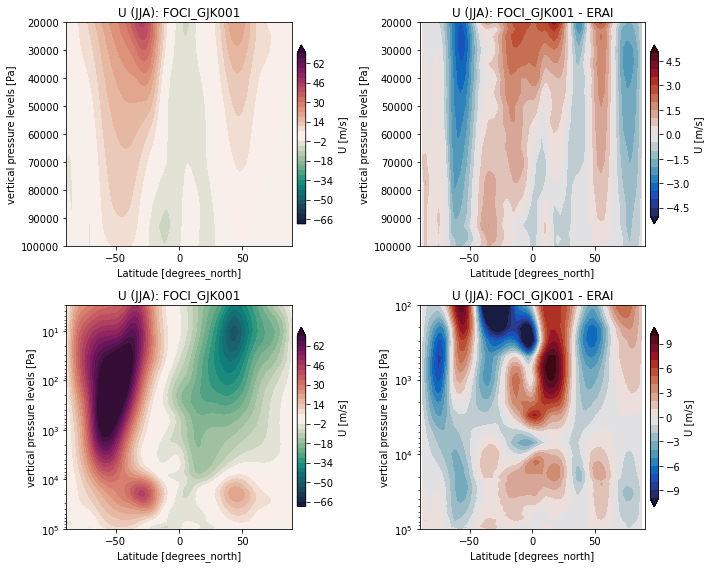

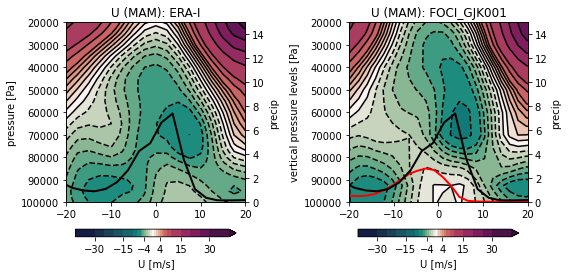

In [18]:
# Plot settings
prj = ccrs.PlateCarree()
umin1 = -70
umax1 = 70
umin2 = -5
umax2 = 5
umin3 = -10
umax3 = 10

ulevels1 = np.linspace(umin1,umax1,36)
ulevels2 = np.linspace(umin2,umax2,21)
ulevels3 = np.linspace(umin3,umax3,21)

umap1 = cmocean.cm.curl
umap2 = cmocean.cm.balance

# ERA + GPCP
if machine == 'sci':
    era_u = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/u/u-eraint_monthly_0.75deg_1979-2016.nc'
    gpcp = '/data/user/swahl/reanalysis_obs/GPCP/precip.mon.mean.1979-01_2014-07.nc'
elif machine == 'nesh':
    era_u = '/gxfs_work1/geomar/smomw352/reanalysis_obs/u-eraint-37plevels-monthly-1979-20190228.nc'
    gpcp = '/gxfs_work1/geomar/smomw352/reanalysis_obs/precip.mon.mean.1979-01_2014-07.nc'
    

ds_era_u = xr.open_dataset(era_u).rename({'lev':'pressure_levels'})
u_ei = ds_era_u['U'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
u_zm_ei = u_ei.mean('lon')

# GPCP

ds_gpcp = xr.open_dataset(gpcp)
tp_gpcp = ds_gpcp['precip'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')

for i in range(0,len(ds_pl_all)):
    exp = exp_list[i]
    ds_pl = ds_pl_all[i]
    ds_sfc = ds_sfc_all[i]
    
    u = ds_pl['u'].groupby('time.season').mean('time') 
    u_zm = u.mean('lon')
    
    u_zm_i = u_zm.interp_like(u_zm_ei)
    
    for season in ['DJF','JJA']:
        fig = plt.figure(figsize=(10,8))
        axs = []
        axs.append( fig.add_subplot(2,2,1) )
        axs.append( fig.add_subplot(2,2,2) )
        axs.append( fig.add_subplot(2,2,3) )
        axs.append( fig.add_subplot(2,2,4) )
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]'}
        #u_zm.sel(season=season).plot(x='lat',y='pressure_levels',ax=axs[0],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        #(u_zm_i - u_zm_ei).sel(season=season).plot(ax=axs[1],cmap=umap2,vmin=umin2,vmax=umax2,cbar_kwargs=ckw)
        #u_zm.sel(season=season).plot(x='lat',y='pressure_levels',ax=axs[2],vmin=umin1,vmax=umax1,cmap=umap1,cbar_kwargs=ckw)
        #(u_zm_i - u_zm_ei).sel(season=season).plot(ax=axs[3],cmap=umap2,vmin=umin3,vmax=umax3,cbar_kwargs=ckw)
        u_zm.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs[0],levels=ulevels1,cmap=umap1,cbar_kwargs=ckw)
        (u_zm_i - u_zm_ei).sel(season=season).plot.contourf(ax=axs[1],cmap=umap2,levels=ulevels2,cbar_kwargs=ckw)
        u_zm.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs[2],levels=ulevels1,cmap=umap1,cbar_kwargs=ckw)
        (u_zm_i - u_zm_ei).sel(season=season).plot.contourf(ax=axs[3],cmap=umap2,levels=ulevels3,cbar_kwargs=ckw)
        
        #u_zm.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs[1],levels=ulevels1[::4],colors='g')
        #u_zm.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs[3],levels=ulevels1[::4],colors='g')
        
        axs[0].set_title('U (%s): %s' % (season,exp))
        axs[1].set_title('U (%s): %s - ERAI' % (season,exp))
        axs[2].set_title('U (%s): %s' % (season,exp))
        axs[3].set_title('U (%s): %s - ERAI' % (season,exp))
        
        for ax in axs[0:2]:
            ax.set_ylim([20000,100000])
            
        for ax in axs:
            ax.invert_yaxis()
        
        for ax in axs[2:]:
            ax.set_yscale('log')
        
        fig.tight_layout()
        fig.savefig('u_biases_%s.png' % (season,),format='png',dpi=600)
    
    
    # Precip
    tp = ds_sfc['tp'].groupby('time.season').mean('time')
    tp_ta = tp.sel(lon=slice(320,350)).mean('lon') * 1000  #mm/d
    tp_ta_gpcp = tp_gpcp.sel(lon=slice(320,350)).mean('lon')
    
    fig2 = plt.figure(figsize=(8,4))
    axs2 = []
    axs2.append( fig2.add_subplot(1,2,1) )
    axs2.append( fig2.add_subplot(1,2,2) )
    
    umin1 = -20
    umax1 = 20
    tmp = np.array([1,2,3,4,5,6,8,10,15,20,25,30,40])
    tmp0 = np.array([0,1,2,3,4,5,6,8,10,15,20,25,30,40])
    ticks = np.array([4,15,30])
    ticks0 = np.array([4,15,30])
    ulevels = np.concatenate([-tmp[::-1], tmp0],axis=0)
    uticks  = np.concatenate([-ticks[::-1], ticks0],axis=0)

    season = 'MAM'
    u_ta_ei = u_ei.sel(lon=slice(320,350)).mean('lon')
    u_ta    = u.sel(lon=slice(320,350)).mean('lon')
    u_ta_i  = u_ta.interp_like(u_ta_ei)
    
    ckw = {'shrink':0.9, 'pad':0.11, 'orientation':'horizontal', 'extend':'both', 'label':'U [m/s]', 'ticks': uticks, 'spacing': 'proportional'}
    u_ta_ei.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs2[0],levels=ulevels,cmap=umap1,cbar_kwargs=ckw)
    u_ta.sel(season=season).plot.contourf(x='lat',y='pressure_levels',ax=axs2[1],levels=ulevels,cmap=umap1,cbar_kwargs=ckw)
    u_ta_ei.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs2[0],levels=ulevels,colors='k')
    u_ta.sel(season=season).plot.contour(x='lat',y='pressure_levels',ax=axs2[1],levels=ulevels,colors='k')
    
    
    ax21 = axs2[0].twinx()
    tp_ta_gpcp.sel(season=season).plot(x='lat',ax=ax21,linestyle='-',c='k',lw=2)
    ax22 = axs2[1].twinx()
    tp_ta.sel(season=season).plot(x='lat',ax=ax22,linestyle='-',c='r',lw=2)
    tp_ta_gpcp.sel(season=season).plot(x='lat',ax=ax22,linestyle='-',c='k',lw=2)
    
    axs2[0].set_title('U (%s): ERA-I' % (season,))
    axs2[1].set_title('U (%s): %s' % (season,exp))
        
    for ax in axs2:
        ax.set_ylim([20000,100000])
        ax.invert_yaxis()
        ax.set_xlim([-20,20])
        ax.set_xlabel('')
    
    for ax in [ax21,ax22]:
        ax.set_title('')
        ax.set_ylim([0,15])
        ax.set_xlabel('')
    
    fig2.tight_layout()
    fig2.savefig('tatl_biases_as_harlass_%s.png' % (exp,),format='png',dpi=600)


## Temperature biases

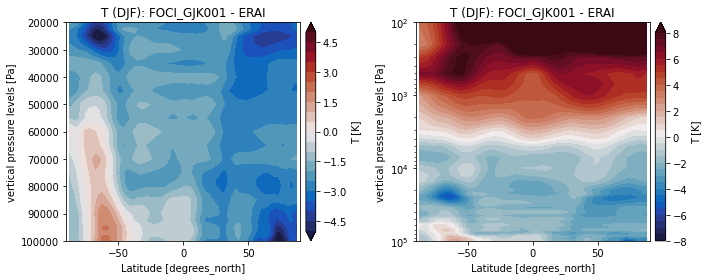

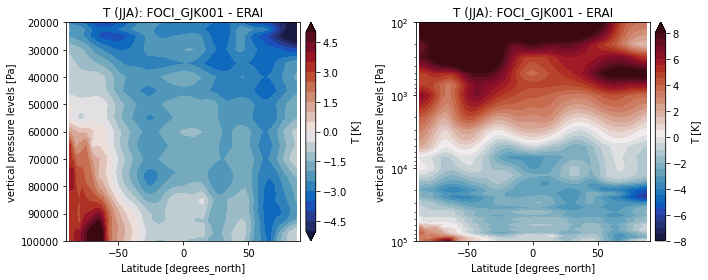

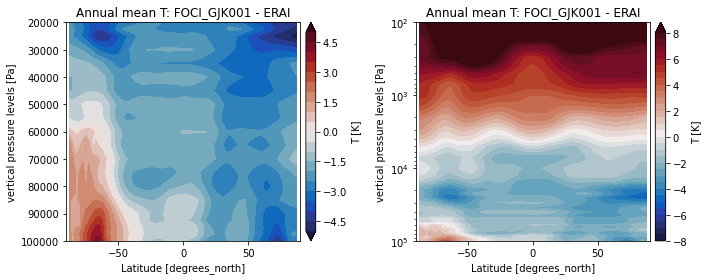

In [10]:
# Plot settings
prj = ccrs.PlateCarree()
tmin1 = 210
tmax1 = 300
tmin2 = -5
tmax2 = 5
tmin3 = -8
tmax3 = 8

tlevels1 = np.linspace(tmin1,tmax1,21)
tlevels2 = np.linspace(tmin2,tmax2,21)
tlevels3 = np.linspace(tmin3,tmax3,33)

tmap1 = cmocean.cm.thermal
tmap2 = cmocean.cm.balance

# ERA-Int
if machine == 'sci':
    era_t = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/t/t-eraint_monthly_0.75deg_1979-2016.nc'
elif machine == 'nesh':
    era_t = '/gxfs_work1/geomar/smomw352/reanalysis_obs/t-eraint-37plevels-monthly-1979-20190228.nc'
ds_era_t = xr.open_dataset(era_t).rename({'lev':'pressure_levels'})
t_ei = ds_era_t['T'].sel(time=slice('1980-01-01','2010-01-01')).groupby('time.season').mean('time')
t_zm_ei = t_ei.mean('lon')

for i in range(0,len(ds_pl_all)):
    exp = exp_list[i]
    ds_pl = ds_pl_all[i]
    ds_sfc = ds_sfc_all[i]
    
    t = ds_pl['t'][-360:].groupby('time.season').mean('time') 
    t_zm = t.mean('lon')
    
    t_zm_i = t_zm.interp_like(t_zm_ei)
    
    for season in ['DJF','JJA','Ann']:
        fig = plt.figure(figsize=(10,4))
        axs = []
        axs.append( fig.add_subplot(1,2,1) )
        axs.append( fig.add_subplot(1,2,2) )
        
        ckw = {'shrink':1.0, 'pad':0.02, 'extend':'both', 'label':'T [K]'}
        if season == 'Ann':
            zplot = (t_zm_i - t_zm_ei).mean('season')
        else:
            zplot = (t_zm_i - t_zm_ei).sel(season=season)
        
        zplot.plot.contourf(ax=axs[0],cmap=tmap2,levels=tlevels2,cbar_kwargs=ckw)
        zplot.plot.contourf(ax=axs[1],cmap=tmap2,levels=tlevels3,cbar_kwargs=ckw)
        
        if season == 'Ann':
            axs[0].set_title('Annual mean T: %s - ERAI' % (exp,))
            axs[1].set_title('Annual mean T: %s - ERAI' % (exp,))
        else:
            axs[0].set_title('T (%s): %s - ERAI' % (season,exp))
            axs[1].set_title('T (%s): %s - ERAI' % (season,exp))
        
        axs[0].set_ylim([20000,100000])
        axs[1].set_ylim([100,100000])
        
        for ax in axs:
            ax.invert_yaxis()
        
        axs[1].set_yscale('log')
        
        fig.tight_layout()
        fig.savefig('t_biases_%s.png' % (season,),format='png',dpi=600)

## Radiation, model vs CERES

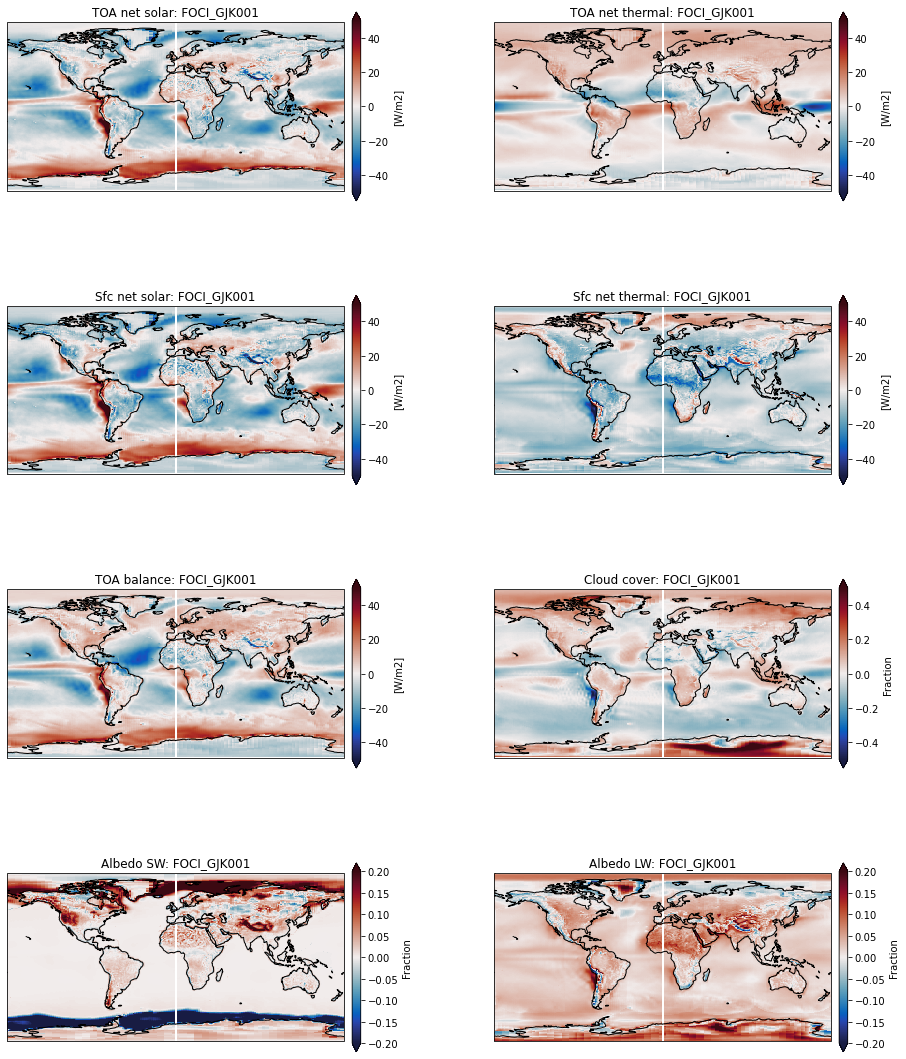

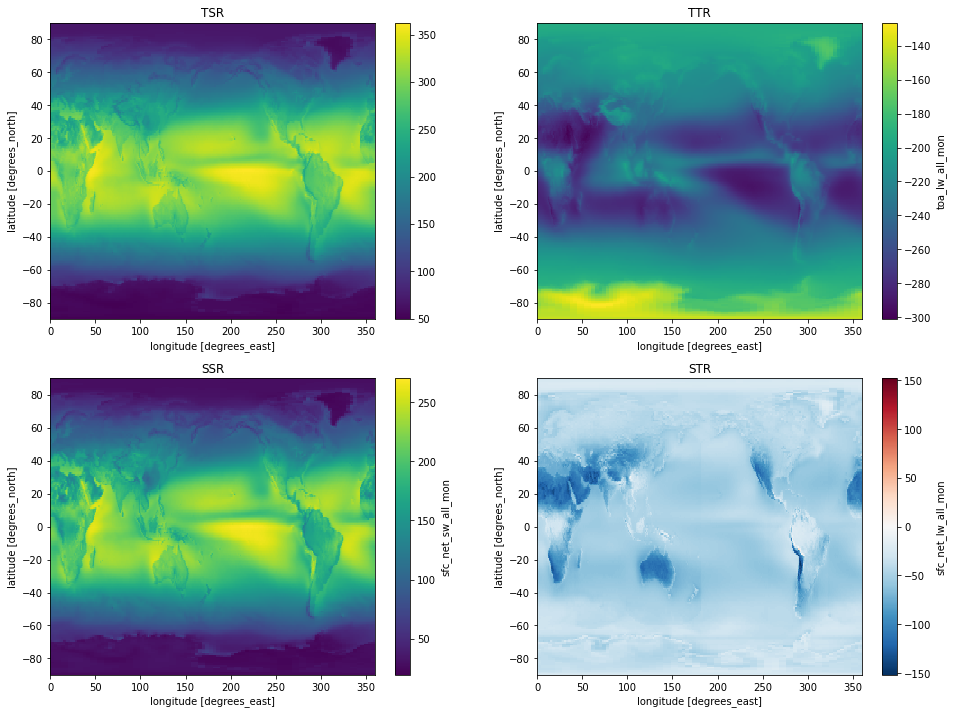

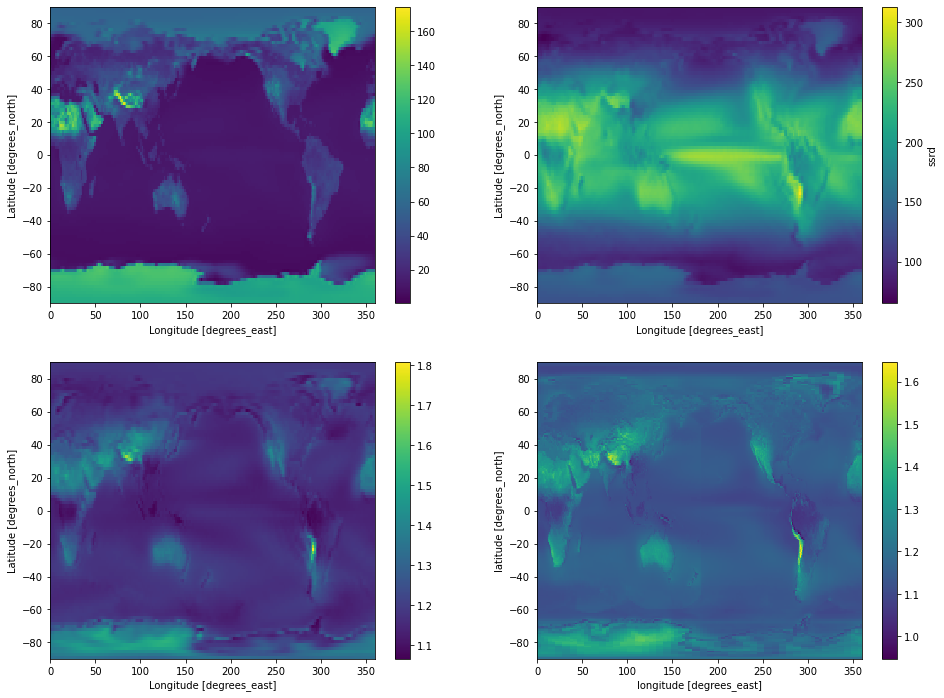

In [40]:
if machine == 'sci':
    print('no ceres data')
elif machine == 'nesh':
    ceres = '/gxfs_work1/geomar/smomw352/ceres/CERES_EBAF_Ed4.1.nc'

ds_c = xr.open_dataset(ceres)

# Plot settings
prj = ccrs.PlateCarree()
hmin2 = -50
hmax2 = 50
tcmin2 = -0.5
tcmax2 = 0.5
amin2 = -0.2
amax2 = 0.2

smap1 = cmocean.cm.solar
hmap1 = cmocean.cm.thermal
hmap2 = cmocean.cm.balance
tcmap2= cmocean.cm.balance
amap2 = cmocean.cm.balance

# Cloud fraction [0,1]
tcc_c = ds_c['cldarea_total_daynight_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time') * 0.01

# Solar outgoing TOA [W/m2]
tsr_out_c = ds_c['toa_sw_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
# Solar incoming TOA [W/m2]
tsr_in_c = ds_c['solar_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
# Solar net TOA (pos down)
tsr_c = (tsr_in_c - tsr_out_c)
# Thermal TOA (pos down) [W/m2]
ttr_c = -ds_c['toa_lw_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')

# Solar net surface (pos down)
ssr_c = ds_c['sfc_net_sw_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
# Thermal net surface (pos down)
str_c = ds_c['sfc_net_lw_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')

# Albedo
ssr_d = ds_c['sfc_sw_down_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
ssr_u = ds_c['sfc_sw_up_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
alb_c = ssr_u / ssr_d

str_d = ds_c['sfc_lw_down_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
str_u = ds_c['sfc_lw_up_all_mon'].sel(time=slice('2000-03-01','2020-01-01')).groupby('time.season').mean('time')
alb_lw_c = str_u / str_d

for i in range(0,len(ds_sfc_all)):
    exp = exp_list[i]
    ds_sfc = ds_sfc_all[i]
    
    # Cloud fraction
    tcc = ds_sfc['tcc'].groupby('time.season').mean('time') 
    tcc_i = tcc.interp_like(tcc_c)
    
    flux_scale = 1.0 / (6*60*60) # [J/m2 -> W/m2]
    
    # Solar TOA
    tsr = ds_sfc['tsr'].groupby('time.season').mean('time') * flux_scale
    tsr_i = tsr.interp_like(tsr_c)
    # Thermal TOA
    ttr = ds_sfc['ttr'].groupby('time.season').mean('time') * flux_scale
    ttr_i = ttr.interp_like(ttr_c)
    # Solar sfc
    ssr = ds_sfc['ssr'].groupby('time.season').mean('time') * flux_scale
    ssr_i = ssr.interp_like(ssr_c)
    # Thermal sfc
    str = ds_sfc['str'].groupby('time.season').mean('time') * flux_scale
    str_i = str.interp_like(str_c)
    
    # Albedo
    ssrd = ds_sfc['ssrd'].groupby('time.season').mean('time') * flux_scale
    ssru = ssr - ssrd
    alb  = -(ssru / ssrd)
    alb_i = alb.interp_like(alb_c)
    
    strd = ds_sfc['strd'].groupby('time.season').mean('time') * flux_scale
    stru = str - strd
    alb_lw = -(stru / strd)
    alb_lw_i = alb_lw.interp_like(alb_lw_c)
    
    if 1:
        fig1,ax1 = plt.subplots(4,2,figsize=(16,20),subplot_kw={'projection':prj})
        axs1 = ax1.flat
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'[W/m2]'}
        (tsr_i - tsr_c).mean('season').plot(ax=axs1[0],cmap=hmap2,vmin=hmin2,vmax=hmax2,cbar_kwargs=ckw)
        axs1[0].set_title('TOA net solar: %s' % (exp,))
        
        (ttr_i - ttr_c).mean('season').plot(ax=axs1[1],cmap=hmap2,vmin=hmin2,vmax=hmax2,cbar_kwargs=ckw)
        axs1[1].set_title('TOA net thermal: %s' % (exp,))
        
        (ssr_i - ssr_c).mean('season').plot(ax=axs1[2],cmap=hmap2,vmin=hmin2,vmax=hmax2,cbar_kwargs=ckw)
        axs1[2].set_title('Sfc net solar: %s' % (exp,))
        
        (str_i - str_c).mean('season').plot(ax=axs1[3],cmap=hmap2,vmin=hmin2,vmax=hmax2,cbar_kwargs=ckw)
        axs1[3].set_title('Sfc net thermal: %s' % (exp,))
        
        (tsr_i - tsr_c + (ttr_i - ttr_c)).mean('season').plot(ax=axs1[4],cmap=hmap2,vmin=hmin2,vmax=hmax2,cbar_kwargs=ckw)
        axs1[4].set_title('TOA balance: %s' % (exp,))
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'Fraction'}
        (tcc_i - tcc_c).mean('season').plot(ax=axs1[5],cmap=tcmap2,vmin=tcmin2,vmax=tcmax2,cbar_kwargs=ckw)
        axs1[5].set_title('Cloud cover: %s' % (exp,))
        
        ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'Fraction'}
        (alb_i - alb_c).mean('season').plot(ax=axs1[6],cmap=amap2,vmin=amin2,vmax=amax2,cbar_kwargs=ckw)
        axs1[6].set_title('Albedo SW: %s' % (exp,))
        
        (alb_lw_i - alb_lw_c).mean('season').plot(ax=axs1[7],cmap=amap2,vmin=amin2,vmax=amax2,cbar_kwargs=ckw)
        axs1[7].set_title('Albedo LW: %s' % (exp,))
        
        for ax in axs1:
            ax.coastlines()
            #ax.set_extent([-100,30,10,90],crs=prj)
        
        #fig1.tight_layout()
        #fig.savefig('u10_msl_biases_%s.png' % (season,),format='png',dpi=600)

fig2, ax2 = plt.subplots(2,2,figsize=(16,12))
axs2 = ax2.flat
tsr_c.mean('season').plot(ax=axs2[0]) ; axs2[0].set_title('TSR')
ttr_c.mean('season').plot(ax=axs2[1]) ; axs2[1].set_title('TTR')
ssr_c.mean('season').plot(ax=axs2[2]) ; axs2[2].set_title('SSR')
str_c.mean('season').plot(ax=axs2[3]) ; axs2[3].set_title('STR')

fig3, ax3 = plt.subplots(2,2,figsize=(16,12))
axs3 = ax3.flat
(-ssru).mean('season').plot(ax=axs3[0])
ssrd.mean('season').plot(ax=axs3[1])
(alb_lw).mean('season').plot(ax=axs3[2])
(alb_lw_c).mean('season').plot(ax=axs3[3])


In [26]:
ds_sfc

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, lat: 96, lon: 192, time: 1200)
Coordinates:
  * lat                   (lat) float32 -89.06 -87.19 -85.31 ... 87.19 89.06
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
    time_centered         (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time                  (time) object 2300-01-16 12:00:00 ... 2399-12-16 12...
Dimensions without coordinates: axis_nbounds
Data variables: (12/43)
    time_centered_bounds  (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    sstk                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ci                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    es                    (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    tclw                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ...                    ...
    swvl1                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl2                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl3                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    swvl4                 (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    sro                   (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
    ssro                  (time, lat, lon) float32 dask.array<chunksize=(120, 96, 192), meta=np.ndarray>
Attributes:
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         0c810368-fe66-48aa-9163-86fa3ed8dac8
    history:      Sun Nov 14 21:27:08 2021: ncks -7 --no-alphabetize -L 1 --c...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...